In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'Bear phase LSTM Experiment'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Prepare Test Data

In [5]:
test_sets = ['accumulation phase data','mark up phase data','distribution phase data','mark down phase data','bull phase data','bear phase data','full cycle data']
test_data = {}

for name in test_sets:

    df = pd.read_csv("{}/test_data.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
            
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    print(X.shape)
    
    y = to_categorical(y, 3)
    
    test_data['{}_X'.format(name)] = X
    test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2004-06-14    93.010002  92.918784 -32.009897  48922600.0     2.0
2004-06-15    91.529999  92.705124 -68.734488  45879300.0     2.0
2004-06-16    90.209999  92.321259 -94.676024  40369000.0     2.0
2004-06-17    89.980003  91.961066 -87.983635  36219100.0     2.0
2004-06-18    89.339996  91.557824 -85.961924  32718400.0     2.0
(248, 15, 4)
            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   115.589996  116.459043 -80.074504 -17684500.0     2.0
2020-01-23   116.099998  116.403805 -70.577262 -12758400.0     2.0
2020-01-24   115.809998  116.312450 -69.789236 -17063500.0     2.0
2020-01-27   114.370003  116.013612 -94.416205 -21446900.0     2.0
2020-01-28   115.860001  115.989979 -34.297465 -14428500.0     2.0
(219, 15, 4)
            previous_1d      EMA_12   willr

## Train Accumulation Phase Stock Data

In [6]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [7]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [8]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

### Creating Training Data and Model

bear phase data\0_acc_data.csv
            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2013-07-29    49.000000  49.438690 -80.861264  113567600.0     2.0
2013-07-30    48.910000  49.357353 -83.014377  111851600.0     2.0
2013-07-31    49.790001  49.423914 -61.961722  113019000.0     2.0
2013-08-01    49.869999  49.492543 -51.169618  113978800.0     2.0
2013-08-02    51.459999  49.795228 -19.306991  115490000.0     0.0


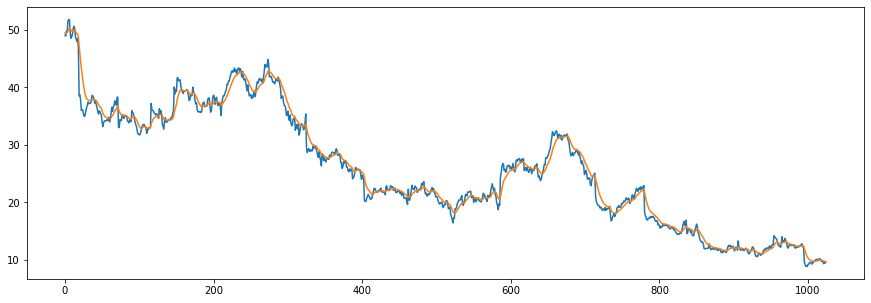

bear phase data\1_acc_data.csv
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


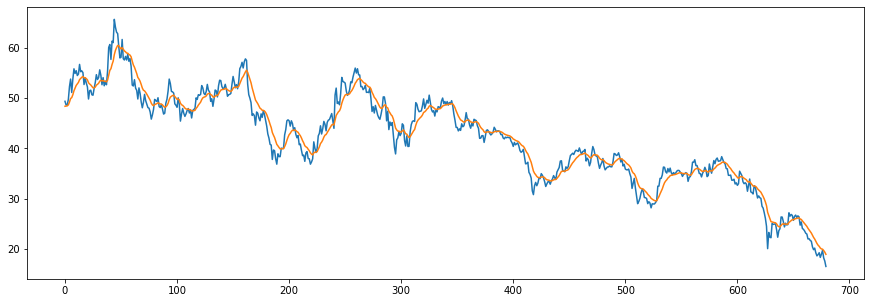

bear phase data\2_acc_data.csv
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2001-04-16    29.000000  28.506905 -34.482761 -99375452.0     2.0
2001-04-17    29.180000  28.610458 -27.586194 -95843852.0     2.0
2001-04-18    28.879999  28.651926 -39.080497 -99108352.0     0.0
2001-04-19    30.709999  28.968553 -17.191311 -87511052.0     2.0
2001-04-20    30.299999  29.173391 -27.118670 -94318852.0     2.0


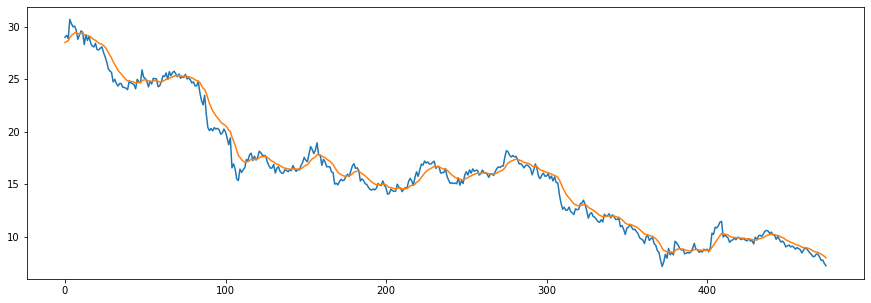

bear phase data\3_acc_data.csv
            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2011-01-03    36.860001  35.273652  -3.166198  661708900.0     2.0
2011-01-04    37.060001  35.548475 -19.542585  686583800.0     2.0
2011-01-05    37.900002  35.910248  -2.078970  718947200.0     2.0
2011-01-06    38.070000  36.242518  -4.500969  741451100.0     2.0
2011-01-07    38.900002  36.651361  -9.220953  780008000.0     0.0


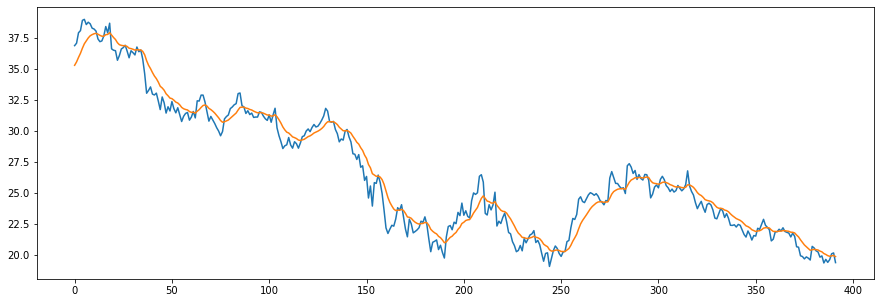

bear phase data\4_acc_data.csv
            previous_1d    EMA_12   willr_14         OBV_7  labels
Date                                                              
2018-01-22         7.19  6.771425  -1.136336  3.248229e+09     2.0
2018-01-23         7.09  6.820437 -14.666621  2.718594e+09     2.0
2018-01-24         7.33  6.898831  -8.333325  3.443507e+09     2.0
2018-01-25         7.28  6.957472 -13.541628  2.874295e+09     2.0
2018-01-26         7.06  6.973246 -36.458322  2.394853e+09     2.0


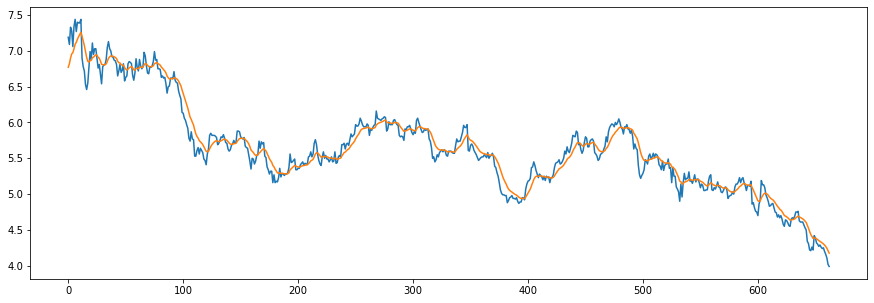

bear phase data\5_acc_data.csv
            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2018-01-23    36.180000  35.813713 -13.991774 -1195100.0     0.0
2018-01-24    36.470001  35.914681  -2.403807  -818600.0     2.0
2018-01-25    36.330002  35.978576 -13.013613 -1233200.0     2.0
2018-01-26    35.900002  35.966488 -54.867110 -1638100.0     2.0
2018-01-29    36.209999  36.003951 -29.245375 -1229100.0     2.0


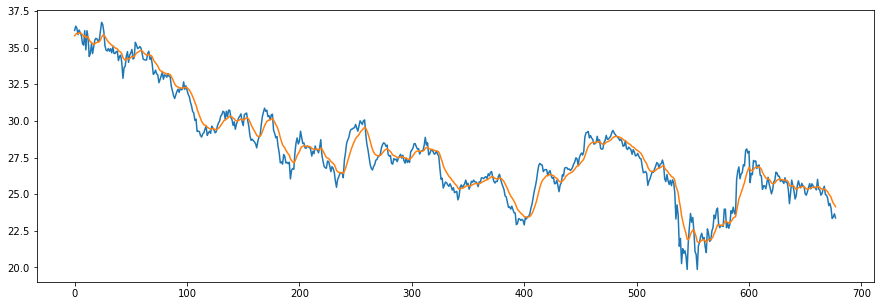

bear phase data\6_acc_data.csv
            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2013-11-18    41.169998  40.276379  -1.421923  6585600.0     2.0
2013-11-19    41.230000  40.423090 -14.056307  6808000.0     2.0
2013-11-20    40.970001  40.507230 -24.498000  6523100.0     2.0
2013-11-21    41.189999  40.612271 -15.662769  6840300.0     2.0
2013-11-22    42.430000  40.891922  -0.595252  7413300.0     0.0


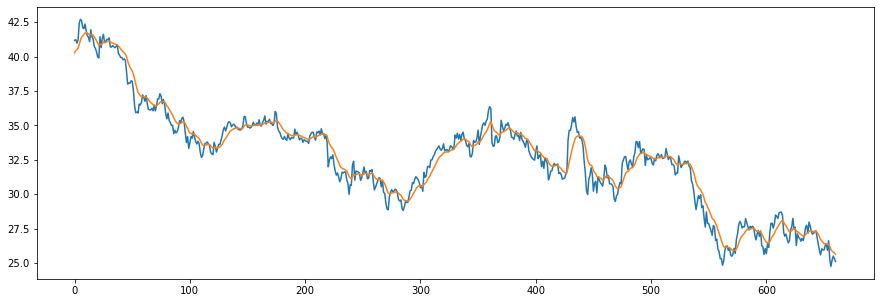

In [9]:
labels = []
sequential = []

for filepath in glob.iglob('bear phase data/*_acc_data.csv'):
    print(filepath)
    seed = 10
    df = pd.read_csv(filepath)
    df.set_index('Date', inplace=True)
    print(df.head())
    
    plt.figure(figsize=(15,5))
    plt.plot(df['previous_1d'].values)
    plt.plot(df['EMA_12'].values)
    plt.show()

    data_15 = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1

In [10]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(4476, 15, 4)

In [11]:
y = labels
y = np.array(y)
y.shape

(4476,)

In [12]:
from collections import Counter

Counter(y)

Counter({2.0: 4068, 1.0: 208, 0.0: 200})

In [13]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [14]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [15]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [17]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

epochs = 0 
histories = {}
log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['accumulation phase data','mark up phase data','distribution phase data','mark down phase data','bull phase data','bear phase data','full cycle data']
    
    for name in test_sets:
        
        print('\n')
        print(name)
        print('\n')
        
        X = test_data['{}_X'.format(name)]
        y = test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("{}/test_data.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(log)
        log.loc[df_length] = logger
        print(log.head(20))
        logger = []

    log.to_csv('{}_{}epochs.csv'.format(experiment,epochs))
    log_hist['{}_epochs_logs'.format(epochs)] = log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "





RUNNING EPOCHS 0 - 20



Epoch 1/20
 1/28 [>.............................] - ETA: 0s - loss: 0.2695 - accuracy: 0.5781 - mse: 0.3229 - weighted_accuracy: 0.4986 - weighted_mse: 0.4073WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
28/28 [==============================] - 1s 43ms/step - loss: 0.2895 - accuracy: 0.4986 - mse: 0.4641 - weighted_accuracy: 0.3078 - weighted_mse: 0.5343 - val_loss: 0.2994 - val_accuracy: 0.0469 - val_mse: 0.3541 - val_weighted_accuracy: 0.0469 - val_weighted_mse: 0.3541
Epoch 2/20
28/28 [==============================] - 0s 9ms/step - loss: 0.2121 - accuracy: 0.3321 - mse: 0.7874 - weighted_accuracy: 0.4397 - weighted_mse: 0.7607 - val_loss: 0.2914 - val_accuracy: 0.0469 - val_mse: 0.3796 - val_weighted_accuracy: 0.04

7/7 [==============================] - 0s 3ms/step - loss: 0.1782 - accuracy: 0.4658 - mse: 1.1816 - weighted_accuracy: 0.4658 - weighted_mse: 1.1816
Test loss: 0.1782158464193344
Test accuracy: 0.465753436088562


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 85
actual holds but predicted sell: 24
actual predicted holds: 92
Percentage buys correct: 7.446808510638298%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 93.87755102040816%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 49.46236559139785%
Percentage high sells correct: 51.851851851851855%
Percentage mid holds correct: 87.75510204081633%


Capital: 100
Share price: $0.3296552589924817
Shares owned at the moment: 302
Cash capital at the moment: $0.1703330916772643


Price in

9/9 [==============================] - 0s 3ms/step - loss: 0.1853 - accuracy: 0.3129 - mse: 1.2376 - weighted_accuracy: 0.3129 - weighted_mse: 1.2376
Test loss: 0.18525773286819458
Test accuracy: 0.31294962763786316


number of predictions: 278
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 4
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 137
actual holds but predicted sell: 37
actual predicted holds: 75
Percentage buys correct: 6.0%
Percentage sells correct: 7.317073170731708%
Percentage holds correct: 86.20689655172414%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 40.26845637583892%
Percentage high sells correct: 43.90243902439025%
Percentage mid holds correct: 80.45977011494253%


Capital: 100
Share price: $0.8557023478457203
Shares owned at the moment: 116
Cash capital at the moment: $0.4655586009336474


Price increase fro

19/19 [==============================] - 0s 4ms/step - loss: 0.1827 - accuracy: 0.4000 - mse: 1.2258 - weighted_accuracy: 0.4000 - weighted_mse: 1.2258
Test loss: 0.18268415331840515
Test accuracy: 0.4000000059604645


number of predictions: 595
actual predicted buys: 22
actual buys but predicted sell: 4
actual buys but predicted hold: 6
actual sells but predicted buy: 7
actual predicted sells: 10
actual sells but predicted hold: 10
actual holds but predicted buy: 249
actual holds but predicted sell: 81
actual predicted holds: 206
Percentage buys correct: 7.913669064748201%
Percentage sells correct: 10.526315789473685%
Percentage holds correct: 92.7927927927928%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 47.292418772563174%
Percentage high sells correct: 53.68421052631579%
Percentage mid holds correct: 85.13513513513513%


Capital: 100
Share price: $0.7488095723945759
Shares owned at the moment: 133
Cash capital at the moment: $0.1344497704180867


29/29 [==============================] - 0s 3ms/step - loss: 0.1870 - accuracy: 0.3381 - mse: 1.2692 - weighted_accuracy: 0.3381 - weighted_mse: 1.2692
Test loss: 0.186956986784935
Test accuracy: 0.3380588889122009


number of predictions: 917
actual predicted buys: 30
actual buys but predicted sell: 1
actual buys but predicted hold: 15
actual sells but predicted buy: 12
actual predicted sells: 17
actual sells but predicted hold: 11
actual holds but predicted buy: 445
actual holds but predicted sell: 123
actual predicted holds: 263
Percentage buys correct: 6.160164271047228%
Percentage sells correct: 12.056737588652481%
Percentage holds correct: 91.00346020761246%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 43.3264887063655%
Percentage high sells correct: 51.06382978723404%
Percentage mid holds correct: 83.68055555555556%


Capital: 100
Share price: $0.3088084010225731
Shares owned at the moment: 322
Cash capital at the moment: $0.2902450316259575


Epoch 1/20
28/28 [==============================] - 3s 95ms/step - loss: 0.1476 - accuracy: 0.3494 - mse: 1.4656 - weighted_accuracy: 0.6726 - weighted_mse: 1.3855 - val_loss: 0.1860 - val_accuracy: 0.3438 - val_mse: 1.3144 - val_weighted_accuracy: 0.3438 - val_weighted_mse: 1.3144
Epoch 2/20
28/28 [==============================] - 0s 11ms/step - loss: 0.1460 - accuracy: 0.3631 - mse: 1.4954 - weighted_accuracy: 0.6912 - weighted_mse: 1.4089 - val_loss: 0.1841 - val_accuracy: 0.3717 - val_mse: 1.3539 - val_weighted_accuracy: 0.3717 - val_weighted_mse: 1.3539
Epoch 3/20
28/28 [==============================] - 0s 10ms/step - loss: 0.1455 - accuracy: 0.3377 - mse: 1.5277 - weighted_accuracy: 0.6854 - weighted_mse: 1.4346 - val_loss: 0.1750 - val_accuracy: 0.4699 - val_mse: 1.3621 - val_weighted_accuracy: 0.4699 - val_weighted_mse: 1.3621
Epoch 4/20
28/28 [==============================] - 0s 10ms/step - loss: 0.1443 - accuracy: 0.3737 - mse: 1.5233 - weighted_accuracy: 0.6892 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.1884 - accuracy: 0.4247 - mse: 1.7147 - weighted_accuracy: 0.4247 - weighted_mse: 1.7147
Test loss: 0.18835631012916565
Test accuracy: 0.42465752363204956


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 2
actual holds but predicted buy: 54
actual holds but predicted sell: 69
actual predicted holds: 78
Percentage buys correct: 10.0%
Percentage sells correct: 11.538461538461538%
Percentage holds correct: 96.29629629629629%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 61.016949152542374%
Percentage high sells correct: 51.282051282051285%
Percentage mid holds correct: 85.18518518518519%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Price increase 

9/9 [==============================] - 0s 4ms/step - loss: 0.1873 - accuracy: 0.3849 - mse: 1.8120 - weighted_accuracy: 0.3849 - weighted_mse: 1.8120
Test loss: 0.18732790648937225
Test accuracy: 0.384892076253891


number of predictions: 278
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 10
actual sells but predicted hold: 2
actual holds but predicted buy: 86
actual holds but predicted sell: 76
actual predicted holds: 87
Percentage buys correct: 10.309278350515465%
Percentage sells correct: 11.627906976744185%
Percentage holds correct: 91.57894736842105%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 51.041666666666664%
Percentage high sells correct: 52.325581395348834%
Percentage mid holds correct: 84.21052631578948%


Capital: 100
Share price: $0.8557023478457203
Shares owned at the moment: 116
Cash capital at the moment: $0.4655586009336474


P

19/19 [==============================] - 0s 4ms/step - loss: 0.1926 - accuracy: 0.3563 - mse: 1.7896 - weighted_accuracy: 0.3563 - weighted_mse: 1.7896
Test loss: 0.1925784945487976
Test accuracy: 0.35630252957344055


number of predictions: 595
actual predicted buys: 18
actual buys but predicted sell: 5
actual buys but predicted hold: 9
actual sells but predicted buy: 4
actual predicted sells: 17
actual sells but predicted hold: 6
actual holds but predicted buy: 165
actual holds but predicted sell: 194
actual predicted holds: 177
Percentage buys correct: 9.62566844919786%
Percentage sells correct: 7.87037037037037%
Percentage holds correct: 92.1875%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 54.01069518716577%
Percentage high sells correct: 50.46296296296296%
Percentage mid holds correct: 83.24607329842932%


Capital: 100
Share price: $0.7488095723945759
Shares owned at the moment: 133
Cash capital at the moment: $0.1344497704180867


Price incre

29/29 [==============================] - 0s 4ms/step - loss: 0.1929 - accuracy: 0.3773 - mse: 1.8176 - weighted_accuracy: 0.3773 - weighted_mse: 1.8176
Test loss: 0.19290290772914886
Test accuracy: 0.3773173391819


number of predictions: 917
actual predicted buys: 27
actual buys but predicted sell: 3
actual buys but predicted hold: 16
actual sells but predicted buy: 4
actual predicted sells: 24
actual sells but predicted hold: 12
actual holds but predicted buy: 267
actual holds but predicted sell: 269
actual predicted holds: 295
Percentage buys correct: 9.060402684563758%
Percentage sells correct: 8.108108108108109%
Percentage holds correct: 91.3312693498452%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 48.65771812080537%
Percentage high sells correct: 48.310810810810814%
Percentage mid holds correct: 85.09316770186335%


Capital: 100
Share price: $0.3610541051067073
Shares owned at the moment: 276
Cash capital at the moment: $0.07502692477278572



Epoch 1/20
28/28 [==============================] - 0s 15ms/step - loss: 0.1273 - accuracy: 0.4897 - mse: 1.7341 - weighted_accuracy: 0.7645 - weighted_mse: 1.6705 - val_loss: 0.1953 - val_accuracy: 0.4074 - val_mse: 1.8209 - val_weighted_accuracy: 0.4074 - val_weighted_mse: 1.8209
Epoch 2/20
28/28 [==============================] - 0s 11ms/step - loss: 0.1262 - accuracy: 0.4796 - mse: 1.7728 - weighted_accuracy: 0.7590 - weighted_mse: 1.7027 - val_loss: 0.1949 - val_accuracy: 0.3940 - val_mse: 1.9310 - val_weighted_accuracy: 0.3940 - val_weighted_mse: 1.9310
Epoch 3/20
28/28 [==============================] - 0s 10ms/step - loss: 0.1255 - accuracy: 0.4648 - mse: 1.8096 - weighted_accuracy: 0.7476 - weighted_mse: 1.7439 - val_loss: 0.1783 - val_accuracy: 0.4855 - val_mse: 1.8134 - val_weighted_accuracy: 0.4855 - val_weighted_mse: 1.8134
Epoch 4/20
28/28 [==============================] - 0s 11ms/step - loss: 0.1252 - accuracy: 0.4885 - mse: 1.8066 - weighted_accuracy: 0.7680 - weighted

7/7 [==============================] - 0s 4ms/step - loss: 0.1795 - accuracy: 0.5023 - mse: 2.1308 - weighted_accuracy: 0.5023 - weighted_mse: 2.1308
Test loss: 0.1795284003019333
Test accuracy: 0.5022830963134766


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 2
actual holds but predicted buy: 43
actual holds but predicted sell: 63
actual predicted holds: 95
Percentage buys correct: 12.244897959183673%
Percentage sells correct: 12.5%
Percentage holds correct: 96.93877551020408%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 64.58333333333333%
Percentage high sells correct: 54.166666666666664%
Percentage mid holds correct: 87.75510204081633%


Capital: 100
Share price: $0.22214604861775533
Shares owned at the moment: 448
Cash capital at the moment: $0.2048862873485291


Price increase fro

9/9 [==============================] - 0s 5ms/step - loss: 0.1828 - accuracy: 0.4604 - mse: 2.1908 - weighted_accuracy: 0.4604 - weighted_mse: 2.1908
Test loss: 0.18278516829013824
Test accuracy: 0.46043166518211365


number of predictions: 278
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 3
actual holds but predicted buy: 68
actual holds but predicted sell: 72
actual predicted holds: 109
Percentage buys correct: 12.658227848101266%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 92.37288135593221%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 50.0%
Percentage high sells correct: 54.32098765432099%
Percentage mid holds correct: 84.7457627118644%


Capital: 100
Share price: $0.8557023478457203
Shares owned at the moment: 116
Cash capital at the moment: $0.4655586009336474


Price increase f

19/19 [==============================] - 0s 4ms/step - loss: 0.1932 - accuracy: 0.4286 - mse: 2.1710 - weighted_accuracy: 0.4286 - weighted_mse: 2.1710
Test loss: 0.19321835041046143
Test accuracy: 0.4285714328289032


number of predictions: 595
actual predicted buys: 12
actual buys but predicted sell: 5
actual buys but predicted hold: 15
actual sells but predicted buy: 4
actual predicted sells: 16
actual sells but predicted hold: 7
actual holds but predicted buy: 137
actual holds but predicted sell: 172
actual predicted holds: 227
Percentage buys correct: 7.8431372549019605%
Percentage sells correct: 8.290155440414507%
Percentage holds correct: 91.16465863453816%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 54.248366013071895%
Percentage high sells correct: 49.22279792746114%
Percentage mid holds correct: 81.85483870967742%


Capital: 100
Share price: $0.7488095723945759
Shares owned at the moment: 133
Cash capital at the moment: $0.134449770418086

29/29 [==============================] - 0s 4ms/step - loss: 0.1906 - accuracy: 0.4744 - mse: 2.2198 - weighted_accuracy: 0.4744 - weighted_mse: 2.2198
Test loss: 0.19063492119312286
Test accuracy: 0.4743729531764984


number of predictions: 917
actual predicted buys: 21
actual buys but predicted sell: 3
actual buys but predicted hold: 22
actual sells but predicted buy: 5
actual predicted sells: 25
actual sells but predicted hold: 10
actual holds but predicted buy: 203
actual holds but predicted sell: 239
actual predicted holds: 389
Percentage buys correct: 9.170305676855895%
Percentage sells correct: 9.363295880149813%
Percentage holds correct: 92.39904988123516%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 50.21834061135371%
Percentage high sells correct: 50.93632958801498%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.3610541051067073
Shares owned at the moment: 276
Cash capital at the moment: $0.0750269247727857

Epoch 1/20
28/28 [==============================] - 0s 16ms/step - loss: 0.1099 - accuracy: 0.6078 - mse: 2.0435 - weighted_accuracy: 0.8233 - weighted_mse: 2.0228 - val_loss: 0.1994 - val_accuracy: 0.4554 - val_mse: 2.1820 - val_weighted_accuracy: 0.4554 - val_weighted_mse: 2.1820
Epoch 2/20
28/28 [==============================] - 0s 11ms/step - loss: 0.1090 - accuracy: 0.5936 - mse: 2.1032 - weighted_accuracy: 0.8218 - weighted_mse: 2.0830 - val_loss: 0.1886 - val_accuracy: 0.4721 - val_mse: 2.2712 - val_weighted_accuracy: 0.4721 - val_weighted_mse: 2.2712
Epoch 3/20
28/28 [==============================] - 0s 11ms/step - loss: 0.1079 - accuracy: 0.5888 - mse: 2.1265 - weighted_accuracy: 0.8200 - weighted_mse: 2.1054 - val_loss: 0.1696 - val_accuracy: 0.5692 - val_mse: 2.1825 - val_weighted_accuracy: 0.5692 - val_weighted_mse: 2.1825
Epoch 4/20
28/28 [==============================] - 0s 11ms/step - loss: 0.1076 - accuracy: 0.6045 - mse: 2.1329 - weighted_accuracy: 0.8221 - weighted

7/7 [==============================] - 0s 4ms/step - loss: 0.1539 - accuracy: 0.6393 - mse: 2.5251 - weighted_accuracy: 0.6393 - weighted_mse: 2.5251
Test loss: 0.1538536101579666
Test accuracy: 0.6392694115638733


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 32
actual holds but predicted sell: 41
actual predicted holds: 128
Percentage buys correct: 15.384615384615385%
Percentage sells correct: 12.76595744680851%
Percentage holds correct: 96.2406015037594%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 61.53846153846154%
Percentage high sells correct: 53.191489361702125%
Percentage mid holds correct: 87.87878787878788%


Capital: 100
Share price: $0.08447677432766175
Shares owned at the moment: 1180
Cash capital at the moment: $0.04327916066587534


Pri

9/9 [==============================] - 0s 4ms/step - loss: 0.1645 - accuracy: 0.5827 - mse: 2.5700 - weighted_accuracy: 0.5827 - weighted_mse: 2.5700
Test loss: 0.16454361379146576
Test accuracy: 0.5827338099479675


number of predictions: 278
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 7
actual holds but predicted buy: 51
actual holds but predicted sell: 49
actual predicted holds: 149
Percentage buys correct: 13.333333333333334%
Percentage sells correct: 9.25925925925926%
Percentage holds correct: 90.85365853658537%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 47.45762711864407%
Percentage high sells correct: 51.851851851851855%
Percentage mid holds correct: 84.7560975609756%


Capital: 100
Share price: $0.8557023478457203
Shares owned at the moment: 116
Cash capital at the moment: $0.4655586009336474


Price

19/19 [==============================] - 0s 4ms/step - loss: 0.1753 - accuracy: 0.5479 - mse: 2.5155 - weighted_accuracy: 0.5479 - weighted_mse: 2.5155
Test loss: 0.17526543140411377
Test accuracy: 0.5478991866111755


number of predictions: 595
actual predicted buys: 9
actual buys but predicted sell: 4
actual buys but predicted hold: 19
actual sells but predicted buy: 3
actual predicted sells: 11
actual sells but predicted hold: 13
actual holds but predicted buy: 89
actual holds but predicted sell: 141
actual predicted holds: 306
Percentage buys correct: 8.910891089108912%
Percentage sells correct: 7.051282051282051%
Percentage holds correct: 90.53254437869822%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 49.504950495049506%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 82.49258160237389%


Capital: 100
Share price: $0.7488095723945759
Shares owned at the moment: 133
Cash capital at the moment: $0.1344497704180867


Price incre

29/29 [==============================] - 0s 4ms/step - loss: 0.1687 - accuracy: 0.5911 - mse: 2.5541 - weighted_accuracy: 0.5911 - weighted_mse: 2.5541
Test loss: 0.16867056488990784
Test accuracy: 0.5910577774047852


number of predictions: 917
actual predicted buys: 14
actual buys but predicted sell: 1
actual buys but predicted hold: 31
actual sells but predicted buy: 5
actual predicted sells: 18
actual sells but predicted hold: 17
actual holds but predicted buy: 144
actual holds but predicted sell: 177
actual predicted holds: 510
Percentage buys correct: 8.588957055214724%
Percentage sells correct: 9.183673469387756%
Percentage holds correct: 91.39784946236558%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 49.693251533742334%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 85.63734290843806%


Capital: 100
Share price: $0.3610541051067073
Shares owned at the moment: 276
Cash capital at the moment: $0.07502692477278572


Price in

Epoch 1/20
28/28 [==============================] - 0s 15ms/step - loss: 0.0917 - accuracy: 0.7056 - mse: 2.4795 - weighted_accuracy: 0.8747 - weighted_mse: 2.5205 - val_loss: 0.1887 - val_accuracy: 0.5346 - val_mse: 2.6439 - val_weighted_accuracy: 0.5346 - val_weighted_mse: 2.6439
Epoch 2/20
28/28 [==============================] - 0s 11ms/step - loss: 0.0921 - accuracy: 0.6958 - mse: 2.5464 - weighted_accuracy: 0.8652 - weighted_mse: 2.5991 - val_loss: 0.1735 - val_accuracy: 0.5893 - val_mse: 2.7644 - val_weighted_accuracy: 0.5893 - val_weighted_mse: 2.7644
Epoch 3/20
28/28 [==============================] - 0s 11ms/step - loss: 0.0907 - accuracy: 0.6846 - mse: 2.5709 - weighted_accuracy: 0.8629 - weighted_mse: 2.6135 - val_loss: 0.1525 - val_accuracy: 0.6607 - val_mse: 2.8454 - val_weighted_accuracy: 0.6607 - val_weighted_mse: 2.8454
Epoch 4/20
28/28 [==============================] - 0s 9ms/step - loss: 0.0909 - accuracy: 0.6897 - mse: 2.5938 - weighted_accuracy: 0.8650 - weighted_

7/7 [==============================] - 0s 4ms/step - loss: 0.1466 - accuracy: 0.6895 - mse: 3.2992 - weighted_accuracy: 0.6895 - weighted_mse: 3.2992
Test loss: 0.14656445384025574
Test accuracy: 0.689497709274292


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 29
actual holds but predicted sell: 32
actual predicted holds: 140
Percentage buys correct: 14.285714285714286%
Percentage sells correct: 15.789473684210526%
Percentage holds correct: 95.89041095890411%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 62.857142857142854%
Percentage high sells correct: 52.63157894736842%
Percentage mid holds correct: 88.96551724137932%


Capital: 100
Share price: $0.01
Shares owned at the moment: 9972
Cash capital at the moment: $0.0057699999999982765


Price increase

9/9 [==============================] - 0s 4ms/step - loss: 0.1662 - accuracy: 0.6403 - mse: 3.3007 - weighted_accuracy: 0.6403 - weighted_mse: 3.3007
Test loss: 0.1662273406982422
Test accuracy: 0.6402877569198608


number of predictions: 278
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 9
actual holds but predicted buy: 45
actual holds but predicted sell: 37
actual predicted holds: 167
Percentage buys correct: 14.814814814814815%
Percentage sells correct: 7.5%
Percentage holds correct: 90.76086956521739%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 52.83018867924528%
Percentage high sells correct: 52.5%
Percentage mid holds correct: 84.23913043478261%


Capital: 100
Share price: $0.8557023478457203
Shares owned at the moment: 116
Cash capital at the moment: $0.4655586009336474


Price increase from previously b

19/19 [==============================] - 0s 5ms/step - loss: 0.1727 - accuracy: 0.5933 - mse: 3.2069 - weighted_accuracy: 0.5933 - weighted_mse: 3.2069
Test loss: 0.1727154701948166
Test accuracy: 0.5932773351669312


number of predictions: 595
actual predicted buys: 9
actual buys but predicted sell: 4
actual buys but predicted hold: 19
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 17
actual holds but predicted buy: 88
actual holds but predicted sell: 112
actual predicted holds: 336
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 6.451612903225806%
Percentage holds correct: 90.3225806451613%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 49.494949494949495%
Percentage high sells correct: 48.38709677419355%
Percentage mid holds correct: 82.21024258760107%


Capital: 100
Share price: $0.7488095723945759
Shares owned at the moment: 133
Cash capital at the moment: $0.1344497704180867


P

29/29 [==============================] - 0s 4ms/step - loss: 0.1637 - accuracy: 0.6707 - mse: 3.2773 - weighted_accuracy: 0.6707 - weighted_mse: 3.2773
Test loss: 0.16366136074066162
Test accuracy: 0.6706652045249939


number of predictions: 917
actual predicted buys: 12
actual buys but predicted sell: 1
actual buys but predicted hold: 33
actual sells but predicted buy: 3
actual predicted sells: 15
actual sells but predicted hold: 22
actual holds but predicted buy: 117
actual holds but predicted sell: 126
actual predicted holds: 588
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 10.56338028169014%
Percentage holds correct: 91.44634525660965%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 47.72727272727273%
Percentage high sells correct: 51.40845070422535%
Percentage mid holds correct: 85.66978193146417%


Capital: 100
Share price: $0.3610541051067073
Shares owned at the moment: 276
Cash capital at the moment: $0.0750269247727857

Epoch 1/20
28/28 [==============================] - 0s 16ms/step - loss: 0.0751 - accuracy: 0.7726 - mse: 3.1261 - weighted_accuracy: 0.9089 - weighted_mse: 3.2198 - val_loss: 0.1897 - val_accuracy: 0.5792 - val_mse: 3.3470 - val_weighted_accuracy: 0.5792 - val_weighted_mse: 3.3470
Epoch 2/20
28/28 [==============================] - 0s 12ms/step - loss: 0.0760 - accuracy: 0.7634 - mse: 3.2081 - weighted_accuracy: 0.9036 - weighted_mse: 3.3151 - val_loss: 0.1763 - val_accuracy: 0.6116 - val_mse: 3.4478 - val_weighted_accuracy: 0.6116 - val_weighted_mse: 3.4478
Epoch 3/20
28/28 [==============================] - 0s 9ms/step - loss: 0.0745 - accuracy: 0.7615 - mse: 3.2311 - weighted_accuracy: 0.8970 - weighted_mse: 3.3298 - val_loss: 0.1477 - val_accuracy: 0.7243 - val_mse: 3.6489 - val_weighted_accuracy: 0.7243 - val_weighted_mse: 3.6489
Epoch 4/20
28/28 [==============================] - 0s 9ms/step - loss: 0.0750 - accuracy: 0.7564 - mse: 3.2430 - weighted_accuracy: 0.8914 - weighted_m

7/7 [==============================] - 0s 3ms/step - loss: 0.1432 - accuracy: 0.7123 - mse: 4.1966 - weighted_accuracy: 0.7123 - weighted_mse: 4.1966
Test loss: 0.14315173029899597
Test accuracy: 0.7123287916183472


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 22
actual holds but predicted sell: 32
actual predicted holds: 147
Percentage buys correct: 11.538461538461538%
Percentage sells correct: 15.789473684210526%
Percentage holds correct: 94.83870967741936%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 56.0%
Percentage high sells correct: 52.63157894736842%
Percentage mid holds correct: 86.45161290322581%


Capital: 100
Share price: $0.01
Shares owned at the moment: 9972
Cash capital at the moment: $0.0057699999999982765


Price increase from previou

2         -35.065241  


mark down phase data


9/9 [==============================] - 0s 3ms/step - loss: 0.1703 - accuracy: 0.6835 - mse: 4.0903 - weighted_accuracy: 0.6835 - weighted_mse: 4.0903
Test loss: 0.17034316062927246
Test accuracy: 0.6834532618522644


number of predictions: 278
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 10
actual holds but predicted buy: 31
actual holds but predicted sell: 37
actual predicted holds: 181
Percentage buys correct: 17.94871794871795%
Percentage sells correct: 5.128205128205129%
Percentage holds correct: 90.5%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 50.0%
Percentage high sells correct: 46.15384615384615%
Percentage mid holds correct: 84.5%


Capital: 100
Share price: $0.8786198155689652
Shares owned at the moment: 113
Cash capital at the moment: $0.44292973301888

29/29 [==============================] - 0s 3ms/step - loss: 0.1655 - accuracy: 0.6914 - mse: 4.0878 - weighted_accuracy: 0.6914 - weighted_mse: 4.0878
Test loss: 0.16552267968654633
Test accuracy: 0.6913849711418152


number of predictions: 917
actual predicted buys: 10
actual buys but predicted sell: 1
actual buys but predicted hold: 35
actual sells but predicted buy: 2
actual predicted sells: 13
actual sells but predicted hold: 25
actual holds but predicted buy: 100
actual holds but predicted sell: 120
actual predicted holds: 611
Percentage buys correct: 8.928571428571429%
Percentage sells correct: 9.701492537313433%
Percentage holds correct: 91.0581222056632%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 51.785714285714285%
Percentage high sells correct: 48.507462686567166%
Percentage mid holds correct: 85.67164179104478%


Capital: 100
Share price: $0.3610541051067073
Shares owned at the moment: 276
Cash capital at the moment: $0.075026924772785

Epoch 1/20
28/28 [==============================] - 0s 12ms/step - loss: 0.0610 - accuracy: 0.8226 - mse: 4.0047 - weighted_accuracy: 0.9253 - weighted_mse: 4.0925 - val_loss: 0.1953 - val_accuracy: 0.6373 - val_mse: 4.1633 - val_weighted_accuracy: 0.6373 - val_weighted_mse: 4.1633
Epoch 2/20
28/28 [==============================] - 0s 8ms/step - loss: 0.0614 - accuracy: 0.8165 - mse: 4.0826 - weighted_accuracy: 0.9288 - weighted_mse: 4.1909 - val_loss: 0.1768 - val_accuracy: 0.6596 - val_mse: 4.3938 - val_weighted_accuracy: 0.6596 - val_weighted_mse: 4.3938
Epoch 3/20
28/28 [==============================] - 0s 8ms/step - loss: 0.0601 - accuracy: 0.8243 - mse: 4.1235 - weighted_accuracy: 0.9259 - weighted_mse: 4.2294 - val_loss: 0.1579 - val_accuracy: 0.7623 - val_mse: 4.7044 - val_weighted_accuracy: 0.7623 - val_weighted_mse: 4.7044
Epoch 4/20
28/28 [==============================] - 0s 7ms/step - loss: 0.0603 - accuracy: 0.8187 - mse: 4.1590 - weighted_accuracy: 0.9257 - weighted_ms

7/7 [==============================] - 0s 3ms/step - loss: 0.1424 - accuracy: 0.7397 - mse: 5.4265 - weighted_accuracy: 0.7397 - weighted_mse: 5.4265
Test loss: 0.1423666626214981
Test accuracy: 0.7397260069847107


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 23
actual holds but predicted sell: 23
actual predicted holds: 155
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 14.814814814814815%
Percentage holds correct: 93.93939393939394%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 61.53846153846154%
Percentage high sells correct: 55.55555555555556%
Percentage mid holds correct: 86.06060606060606%


Capital: 100
Share price: $0.01
Shares owned at the moment: 9972
Cash capital at the moment: $0.0057699999999982765


Price increase f

9/9 [==============================] - 0s 4ms/step - loss: 0.1777 - accuracy: 0.7266 - mse: 5.2584 - weighted_accuracy: 0.7266 - weighted_mse: 5.2584
Test loss: 0.17772479355335236
Test accuracy: 0.7266187071800232


number of predictions: 278
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 11
actual holds but predicted buy: 24
actual holds but predicted sell: 29
actual predicted holds: 196
Percentage buys correct: 16.666666666666668%
Percentage sells correct: 3.3333333333333335%
Percentage holds correct: 89.90825688073394%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 50.0%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 83.41013824884793%


Capital: 100
Share price: $0.8786198155689652
Shares owned at the moment: 113
Cash capital at the moment: $0.44292973301888594


Price increase from previo

Share price: $0.32037872551020186
Shares owned at the moment: 209
Cash capital at the moment: $0.0010719497957154545


Price increase from previously bought: -56.619055018126055%
Share price: $0.13936552277348946
Shares owned at the moment: 0
Cash capital at the moment: $29.04836587524095


Share price: $0.08919334069815708
Shares owned at the moment: 324
Cash capital at the moment: $0.07025222247599672


Price increase from previously bought: -20.62311271521644%
Share price: $0.07099359447966579
Shares owned at the moment: 0
Cash capital at the moment: $23.008921541206327


Share price: $0.06213966895820577
Shares owned at the moment: 369
Cash capital at the moment: $0.016327466553057945


Price increase from previously bought: -6.589496439939014%
Share price: $0.05820460137304705
Shares owned at the moment: 0
Cash capital at the moment: $21.43476225396412


Share price: $0.0872257599958721
Shares owned at the moment: 245
Cash capital at the moment: $0.005682699178233719




Capital a

6         -96.006693  



RUNNING EPOCHS 140 - 160



Epoch 1/20
28/28 [==============================] - 0s 13ms/step - loss: 0.0492 - accuracy: 0.8662 - mse: 5.1041 - weighted_accuracy: 0.9470 - weighted_mse: 5.0990 - val_loss: 0.1994 - val_accuracy: 0.6875 - val_mse: 5.2305 - val_weighted_accuracy: 0.6875 - val_weighted_mse: 5.2305
Epoch 2/20
28/28 [==============================] - 0s 8ms/step - loss: 0.0492 - accuracy: 0.8617 - mse: 5.1929 - weighted_accuracy: 0.9434 - weighted_mse: 5.2216 - val_loss: 0.1828 - val_accuracy: 0.7199 - val_mse: 5.6061 - val_weighted_accuracy: 0.7199 - val_weighted_mse: 5.6061
Epoch 3/20
28/28 [==============================] - 0s 8ms/step - loss: 0.0483 - accuracy: 0.8648 - mse: 5.2432 - weighted_accuracy: 0.9407 - weighted_mse: 5.2597 - val_loss: 0.1770 - val_accuracy: 0.7656 - val_mse: 5.9659 - val_weighted_accuracy: 0.7656 - val_weighted_mse: 5.9659
Epoch 4/20
28/28 [==============================] - 0s 8ms/step - loss: 0.0478 - accuracy: 0.8584 -

7/7 [==============================] - 0s 3ms/step - loss: 0.1513 - accuracy: 0.7900 - mse: 6.7704 - weighted_accuracy: 0.7900 - weighted_mse: 6.7704
Test loss: 0.15130436420440674
Test accuracy: 0.7899543642997742


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 21
actual holds but predicted sell: 12
actual predicted holds: 168
Percentage buys correct: 12.0%
Percentage sells correct: 14.285714285714286%
Percentage holds correct: 93.33333333333333%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 62.5%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 86.66666666666667%


Capital: 100
Share price: $0.01
Shares owned at the moment: 9972
Cash capital at the moment: $0.0057699999999982765


Price increase from previously bought: 3

7/7 [==============================] - 0s 3ms/step - loss: 0.1832 - accuracy: 0.7212 - mse: 6.2827 - weighted_accuracy: 0.7212 - weighted_mse: 6.2827
Test loss: 0.1832098811864853
Test accuracy: 0.7211538553237915


number of predictions: 208
actual predicted buys: 1
actual buys but predicted sell: 2
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 5
actual holds but predicted buy: 6
actual holds but predicted sell: 39
actual predicted holds: 144
Percentage buys correct: 14.285714285714286%
Percentage sells correct: 10.869565217391305%
Percentage holds correct: 92.90322580645162%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 85.71428571428571%
Percentage high sells correct: 52.17391304347826%
Percentage mid holds correct: 87.66233766233766%


Capital: 100
Share price: $0.09936061724328947
Shares owned at the moment: 1003
Cash capital at the moment: $0.06723948246934697


Pri

29/29 [==============================] - 0s 3ms/step - loss: 0.1732 - accuracy: 0.7775 - mse: 6.6490 - weighted_accuracy: 0.7775 - weighted_mse: 6.6490
Test loss: 0.17319421470165253
Test accuracy: 0.7775354385375977


number of predictions: 917
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 38
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 30
actual holds but predicted buy: 62
actual holds but predicted sell: 72
actual predicted holds: 697
Percentage buys correct: 10.0%
Percentage sells correct: 10.975609756097562%
Percentage holds correct: 91.11111111111111%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 55.714285714285715%
Percentage high sells correct: 45.1219512195122%
Percentage mid holds correct: 85.47120418848168%


Capital: 100
Share price: $0.348221810041456
Shares owned at the moment: 286
Cash capital at the moment: $0.1346858745459656


Price increase

Epoch 2/20
28/28 [==============================] - 0s 8ms/step - loss: 0.0400 - accuracy: 0.8927 - mse: 6.4783 - weighted_accuracy: 0.9568 - weighted_mse: 6.3230 - val_loss: 0.1985 - val_accuracy: 0.7612 - val_mse: 7.1765 - val_weighted_accuracy: 0.7612 - val_weighted_mse: 7.1765
Epoch 3/20
28/28 [==============================] - 0s 11ms/step - loss: 0.0391 - accuracy: 0.8992 - mse: 6.5588 - weighted_accuracy: 0.9611 - weighted_mse: 6.3804 - val_loss: 0.1950 - val_accuracy: 0.7924 - val_mse: 7.5756 - val_weighted_accuracy: 0.7924 - val_weighted_mse: 7.5756
Epoch 4/20
28/28 [==============================] - 0s 12ms/step - loss: 0.0384 - accuracy: 0.8933 - mse: 6.6220 - weighted_accuracy: 0.9590 - weighted_mse: 6.4066 - val_loss: 0.2127 - val_accuracy: 0.7533 - val_mse: 7.7135 - val_weighted_accuracy: 0.7533 - val_weighted_mse: 7.7135
Epoch 5/20
28/28 [==============================] - 0s 12ms/step - loss: 0.0373 - accuracy: 0.9087 - mse: 6.7689 - weighted_accuracy: 0.9645 - weighted_

7/7 [==============================] - 0s 4ms/step - loss: 0.1654 - accuracy: 0.7991 - mse: 8.2523 - weighted_accuracy: 0.7991 - weighted_mse: 8.2523
Test loss: 0.1654285043478012
Test accuracy: 0.7990867495536804


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 19
actual holds but predicted sell: 11
actual predicted holds: 171
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 15.384615384615385%
Percentage holds correct: 92.93478260869566%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 66.66666666666667%
Percentage high sells correct: 61.53846153846154%
Percentage mid holds correct: 86.41304347826087%


Capital: 100
Share price: $0.01
Shares owned at the moment: 9972
Cash capital at the moment: $0.0057699999999982765


Price increase f

9/9 [==============================] - 0s 4ms/step - loss: 0.2128 - accuracy: 0.7734 - mse: 8.1155 - weighted_accuracy: 0.7734 - weighted_mse: 8.1155
Test loss: 0.21282339096069336
Test accuracy: 0.7733812928199768


number of predictions: 278
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 12
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 12
actual holds but predicted buy: 19
actual holds but predicted sell: 19
actual predicted holds: 211
Percentage buys correct: 16.666666666666668%
Percentage sells correct: 0.0%
Percentage holds correct: 89.7872340425532%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 56.52173913043478%
Percentage high sells correct: 47.36842105263158%
Percentage mid holds correct: 83.40425531914893%


Capital: 100
Share price: $0.8786198155689652
Shares owned at the moment: 113
Cash capital at the moment: $0.44292973301888594


Price increase f

29/29 [==============================] - 0s 3ms/step - loss: 0.1897 - accuracy: 0.7852 - mse: 8.2033 - weighted_accuracy: 0.7852 - weighted_mse: 8.2033
Test loss: 0.18970859050750732
Test accuracy: 0.7851690053939819


number of predictions: 917
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 37
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 30
actual holds but predicted buy: 58
actual holds but predicted sell: 70
actual predicted holds: 703
Percentage buys correct: 13.043478260869565%
Percentage sells correct: 10.256410256410257%
Percentage holds correct: 91.2987012987013%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 56.52173913043478%
Percentage high sells correct: 47.43589743589744%
Percentage mid holds correct: 85.56566970091028%


Capital: 100
Share price: $0.348221810041456
Shares owned at the moment: 286
Cash capital at the moment: $0.1346858745459656


P

28/28 [==============================] - 0s 14ms/step - loss: 0.0330 - accuracy: 0.9187 - mse: 7.8627 - weighted_accuracy: 0.9663 - weighted_mse: 7.3697 - val_loss: 0.2382 - val_accuracy: 0.7634 - val_mse: 8.3721 - val_weighted_accuracy: 0.7634 - val_weighted_mse: 8.3721
Epoch 2/20
28/28 [==============================] - 0s 11ms/step - loss: 0.0329 - accuracy: 0.9156 - mse: 7.9124 - weighted_accuracy: 0.9652 - weighted_mse: 7.4967 - val_loss: 0.2177 - val_accuracy: 0.7857 - val_mse: 8.9239 - val_weighted_accuracy: 0.7857 - val_weighted_mse: 8.9239
Epoch 3/20
28/28 [==============================] - 0s 9ms/step - loss: 0.0312 - accuracy: 0.9249 - mse: 8.0294 - weighted_accuracy: 0.9705 - weighted_mse: 7.5706 - val_loss: 0.2247 - val_accuracy: 0.8025 - val_mse: 9.1648 - val_weighted_accuracy: 0.8025 - val_weighted_mse: 9.1648
Epoch 4/20
28/28 [==============================] - 0s 9ms/step - loss: 0.0319 - accuracy: 0.9126 - mse: 8.0805 - weighted_accuracy: 0.9660 - weighted_mse: 7.5884 

7/7 [==============================] - 0s 4ms/step - loss: 0.1842 - accuracy: 0.7900 - mse: 9.9228 - weighted_accuracy: 0.7900 - weighted_mse: 9.9228
Test loss: 0.18420472741127014
Test accuracy: 0.7899543642997742


number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 17
actual holds but predicted sell: 13
actual predicted holds: 171
Percentage buys correct: 0.0%
Percentage sells correct: 13.333333333333334%
Percentage holds correct: 91.93548387096774%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 58.8235294117647%
Percentage high sells correct: 60.0%
Percentage mid holds correct: 85.48387096774194%


Capital: 100
Share price: $0.11976609655428104
Shares owned at the moment: 832
Cash capital at the moment: $0.0805828379219804


Price increase from previously b

7/7 [==============================] - 0s 4ms/step - loss: 0.1963 - accuracy: 0.7644 - mse: 8.9036 - weighted_accuracy: 0.7644 - weighted_mse: 8.9036
Test loss: 0.19631075859069824
Test accuracy: 0.7644230723381042


number of predictions: 208
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 6
actual holds but predicted sell: 29
actual predicted holds: 154
Percentage buys correct: 14.285714285714286%
Percentage sells correct: 11.764705882352942%
Percentage holds correct: 92.21556886227545%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 100.0%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 86.74698795180723%


Capital: 100
Share price: $0.09936061724328947
Shares owned at the moment: 1003
Cash capital at the moment: $0.06723948246934697


Price increase from previou

29/29 [==============================] - 0s 4ms/step - loss: 0.2101 - accuracy: 0.7972 - mse: 9.9095 - weighted_accuracy: 0.7972 - weighted_mse: 9.9095
Test loss: 0.2100781500339508
Test accuracy: 0.7971646785736084


number of predictions: 917
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 38
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 34
actual holds but predicted buy: 52
actual holds but predicted sell: 61
actual predicted holds: 718
Percentage buys correct: 13.114754098360656%
Percentage sells correct: 7.575757575757576%
Percentage holds correct: 90.88607594936708%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 52.459016393442624%
Percentage high sells correct: 46.96969696969697%
Percentage mid holds correct: 84.91761723700887%


Capital: 100
Share price: $0.348221810041456
Shares owned at the moment: 286
Cash capital at the moment: $0.1346858745459656


P

In [18]:
df = log_hist['0_epochs_logs']
df['Profit gained']

0    -23.471638
1     86.890560
2     -0.488389
3    -95.999600
4    313.492697
5     14.533689
6     78.549826
Name: Profit gained, dtype: float64

In [19]:
accumulation_phase_data_acc = []
mark_up_phase_data_acc = []
distribution_phase_data_acc = []
mark_down_phase_data_acc = []
bull_phase_data_acc = []
bear_phase_data_acc = []
full_cycle_data_acc = []

accumulation_phase_data_correct_buys = []
mark_up_phase_data_correct_buys = []
distribution_phase_data_correct_buys = []
mark_down_phase_data_correct_buys = []
bull_phase_data_correct_buys = []
bear_phase_data_correct_buys = []
full_cycle_data_correct_buys = []

accumulation_phase_data_correct_sells = []
mark_up_phase_data_correct_sells = []
distribution_phase_data_correct_sells = []
mark_down_phase_data_correct_sells = []
bull_phase_data_correct_sells = []
bear_phase_data_correct_sells = []
full_cycle_data_correct_sells = []

accumulation_phase_data_correct_holds = []
mark_up_phase_data_correct_holds = []
distribution_phase_data_correct_holds = []
mark_down_phase_data_correct_holds = []
bull_phase_data_correct_holds = []
bear_phase_data_correct_holds = []
full_cycle_data_correct_holds = []

accumulation_phase_data_correct_low_buys = []
mark_up_phase_data_correct_low_buys = []
distribution_phase_data_correct_low_buys = []
mark_down_phase_data_correct_low_buys = []
bull_phase_data_correct_low_buys = []
bear_phase_data_correct_low_buys = []
full_cycle_data_correct_low_buys = []

accumulation_phase_data_correct_high_sells = []
mark_up_phase_data_correct_high_sells = []
distribution_phase_data_correct_high_sells = []
mark_down_phase_data_correct_high_sells = []
bull_phase_data_correct_high_sells = []
bear_phase_data_correct_high_sells = []
full_cycle_data_correct_high_sells = []

accumulation_phase_data_correct_mid_holds = []
mark_up_phase_data_correct_mid_holds = []
distribution_phase_data_correct_mid_holds = []
mark_down_phase_data_correct_mid_holds = []
bull_phase_data_correct_mid_holds = []
bear_phase_data_correct_mid_holds = []
full_cycle_data_correct_mid_holds = []

accumulation_phase_data_profit = []
mark_up_phase_data_profit = []
distribution_phase_data_profit = []
mark_down_phase_data_profit = []
bull_phase_data_profit = []
bear_phase_data_profit = []
full_cycle_data_profit = []

for key,value in log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    accumulation_phase_data_acc.append(acc[0])
    mark_up_phase_data_acc.append(acc[1])
    distribution_phase_data_acc.append(acc[2])
    mark_down_phase_data_acc.append(acc[3]) 
    bull_phase_data_acc.append(acc[4]) 
    bear_phase_data_acc.append(acc[5]) 
    full_cycle_data_acc.append(acc[6]) 

    accumulation_phase_data_correct_buys.append(correct_buys[0])
    mark_up_phase_data_correct_buys.append(correct_buys[1]) 
    distribution_phase_data_correct_buys.append(correct_buys[2]) 
    mark_down_phase_data_correct_buys.append(correct_buys[3]) 
    bull_phase_data_correct_buys.append(correct_buys[4])
    bear_phase_data_correct_buys.append(correct_buys[5]) 
    full_cycle_data_correct_buys.append(correct_buys[6]) 

    accumulation_phase_data_correct_sells.append(correct_sells[0]) 
    mark_up_phase_data_correct_sells.append(correct_sells[1]) 
    distribution_phase_data_correct_sells.append(correct_sells[2]) 
    mark_down_phase_data_correct_sells.append(correct_sells[3]) 
    bull_phase_data_correct_sells.append(correct_sells[4]) 
    bear_phase_data_correct_sells.append(correct_sells[5]) 
    full_cycle_data_correct_sells.append(correct_sells[6])

    accumulation_phase_data_correct_holds.append(correct_holds[0]) 
    mark_up_phase_data_correct_holds.append(correct_holds[1])  
    distribution_phase_data_correct_holds.append(correct_holds[2])  
    mark_down_phase_data_correct_holds.append(correct_holds[3])  
    bull_phase_data_correct_holds.append(correct_holds[4])  
    bear_phase_data_correct_holds.append(correct_holds[5])  
    full_cycle_data_correct_holds.append(correct_holds[6])  

    accumulation_phase_data_correct_low_buys.append(correct_low_buys[0])  
    mark_up_phase_data_correct_low_buys.append(correct_low_buys[1])  
    distribution_phase_data_correct_low_buys.append(correct_low_buys[2])  
    mark_down_phase_data_correct_low_buys.append(correct_low_buys[3])   
    bull_phase_data_correct_low_buys.append(correct_low_buys[4])   
    bear_phase_data_correct_low_buys.append(correct_low_buys[5])  
    full_cycle_data_correct_low_buys.append(correct_low_buys[6])  

    accumulation_phase_data_correct_high_sells.append(correct_high_sells[0]) 
    mark_up_phase_data_correct_high_sells.append(correct_high_sells[1]) 
    distribution_phase_data_correct_high_sells.append(correct_high_sells[2]) 
    mark_down_phase_data_correct_high_sells.append(correct_high_sells[3]) 
    bull_phase_data_correct_high_sells.append(correct_high_sells[4]) 
    bear_phase_data_correct_high_sells.append(correct_high_sells[5]) 
    full_cycle_data_correct_high_sells.append(correct_high_sells[6]) 

    accumulation_phase_data_correct_mid_holds.append(correct_mid_holds[0])  
    mark_up_phase_data_correct_mid_holds.append(correct_mid_holds[1])  
    distribution_phase_data_correct_mid_holds.append(correct_mid_holds[2])   
    mark_down_phase_data_correct_mid_holds.append(correct_mid_holds[3])   
    bull_phase_data_correct_mid_holds.append(correct_mid_holds[4])   
    bear_phase_data_correct_mid_holds.append(correct_mid_holds[5])   
    full_cycle_data_correct_mid_holds.append(correct_mid_holds[6])   

    accumulation_phase_data_profit.append(profit[0]) 
    mark_up_phase_data_profit.append(profit[1]) 
    distribution_phase_data_profit.append(profit[2]) 
    mark_down_phase_data_profit.append(profit[3])  
    bull_phase_data_profit.append(profit[4])  
    bear_phase_data_profit.append(profit[5])  
    full_cycle_data_profit.append(profit[6])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


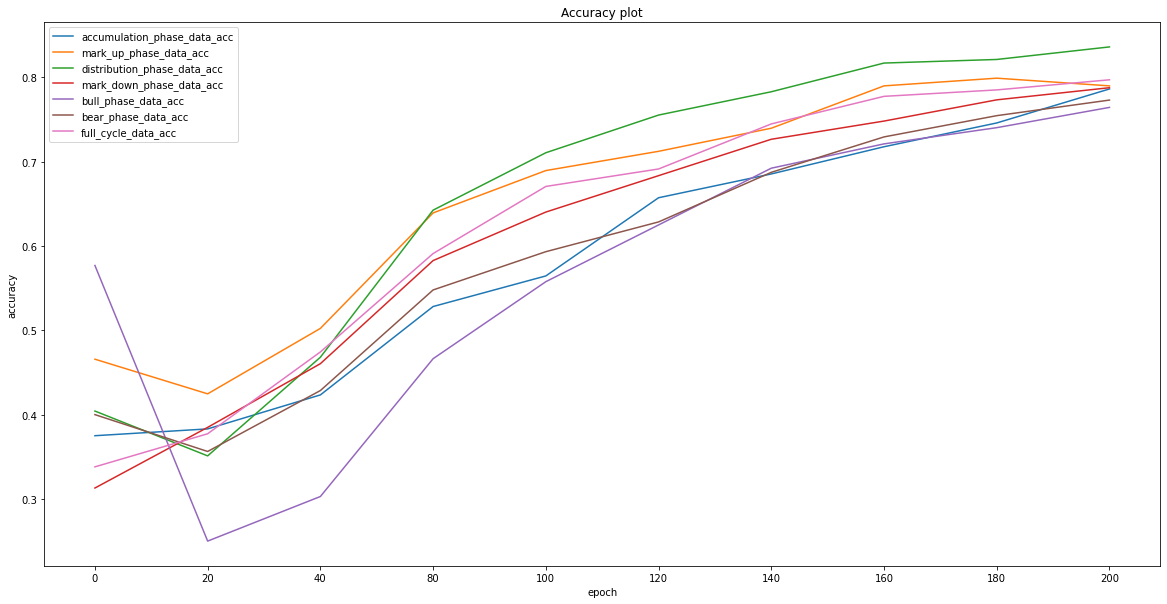

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(accumulation_phase_data_acc)
plt.plot(mark_up_phase_data_acc)
plt.plot(distribution_phase_data_acc)
plt.plot(mark_down_phase_data_acc)
plt.plot(bull_phase_data_acc)
plt.plot(bear_phase_data_acc)
plt.plot(full_cycle_data_acc)
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accumulation_phase_data_acc','mark_up_phase_data_acc','distribution_phase_data_acc','mark_down_phase_data_acc','bull_phase_data_acc','bear_phase_data_acc','full_cycle_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'full_cycle_data_correct_buys')

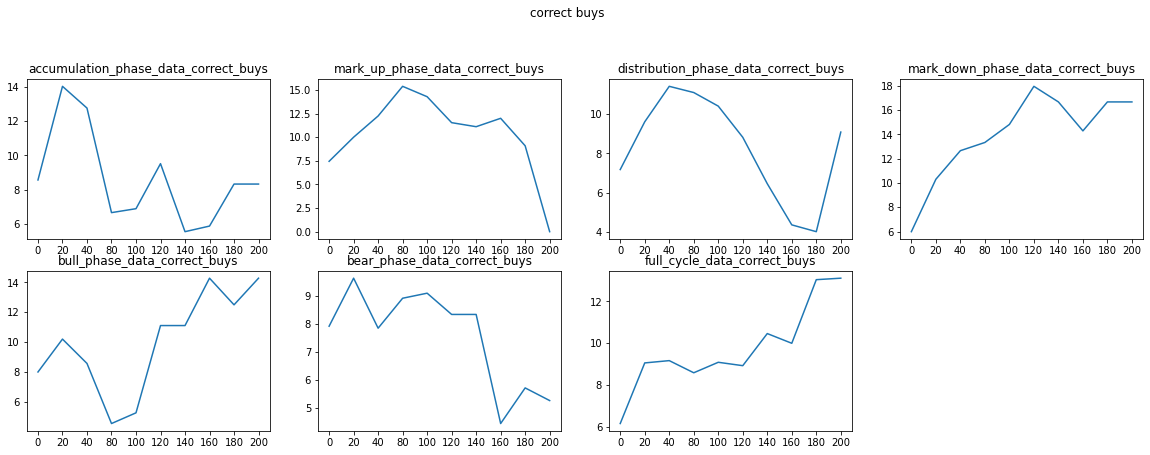

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct buys")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_buys")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_buys")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_buys")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_buys")

Text(0.5, 1.0, 'full_cycle_data_correct_sells')

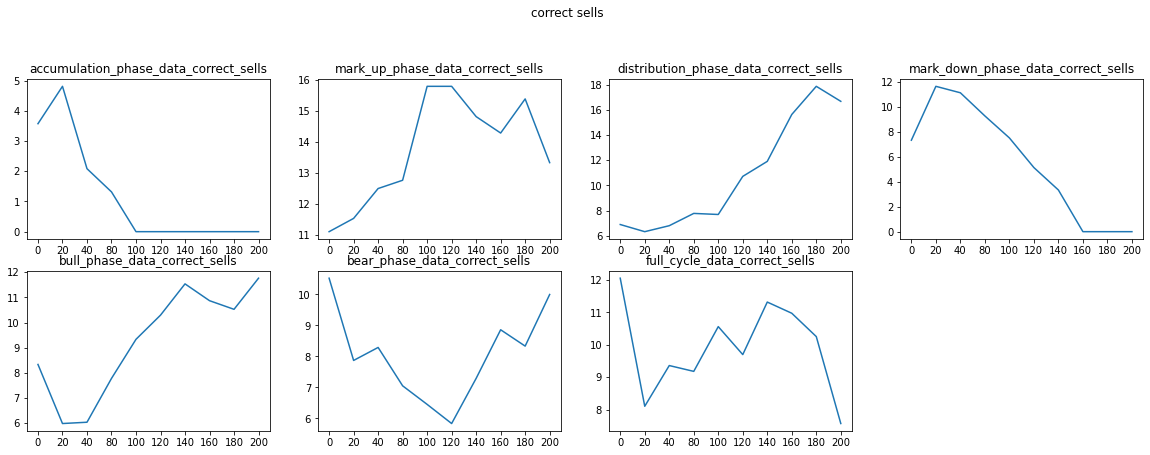

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct sells")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_sells")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_sells")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_sells")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_sells")

Text(0.5, 1.0, 'full_cycle_data_correct_holds')

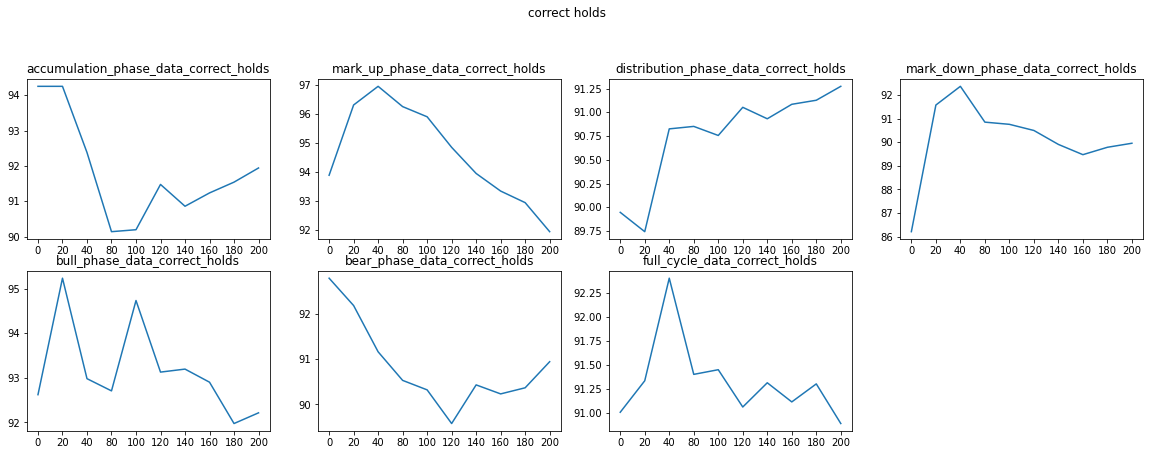

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct holds")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_holds")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_holds")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_holds")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_holds")

Text(0.5, 1.0, 'full_cycle_data_correct_low_buys')

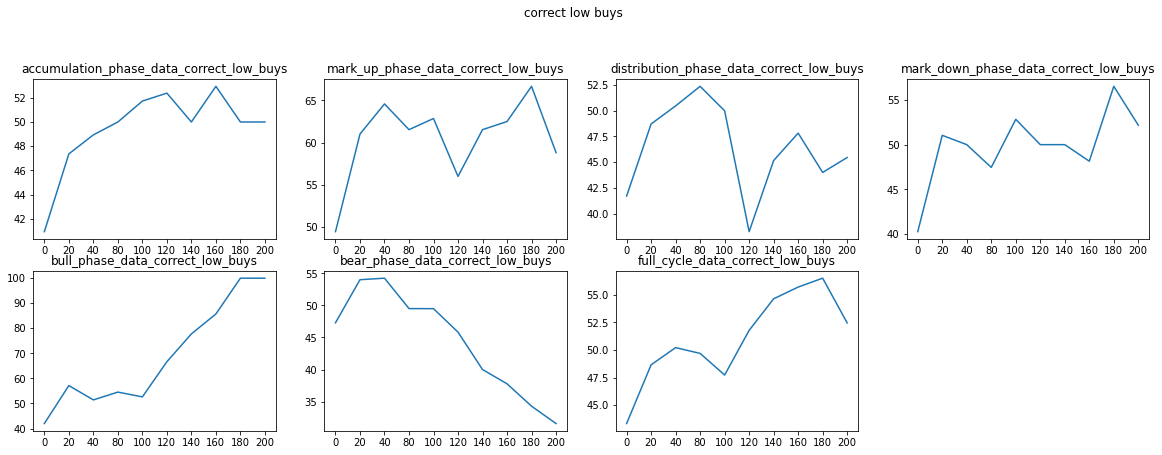

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct low buys")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_low_buys")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_low_buys")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_low_buys")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_low_buys")

Text(0.5, 1.0, 'full_cycle_data_correct_high_sells')

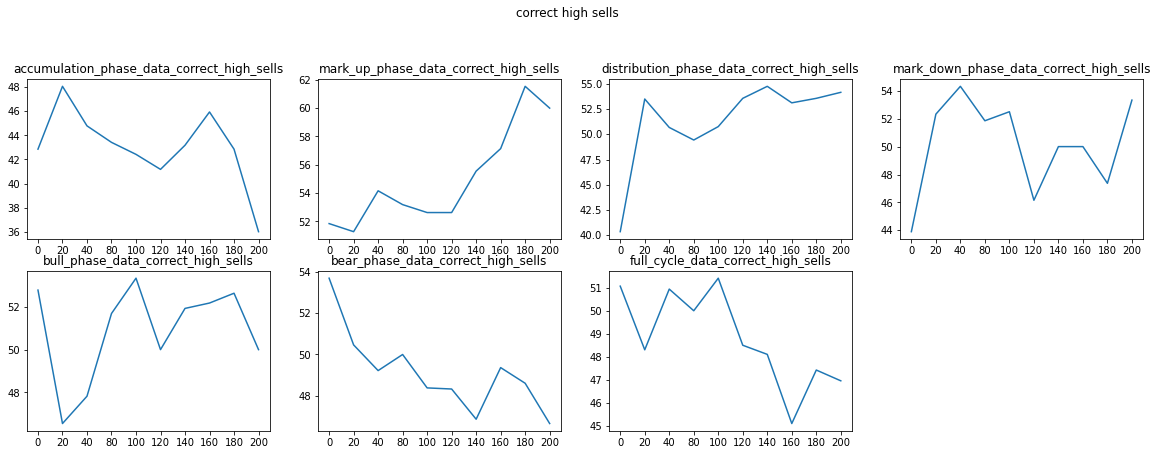

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct high sells")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_high_sells")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_high_sells")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_high_sells")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_high_sells")

Text(0.5, 1.0, 'full_cycle_data_correct_mid_holds')

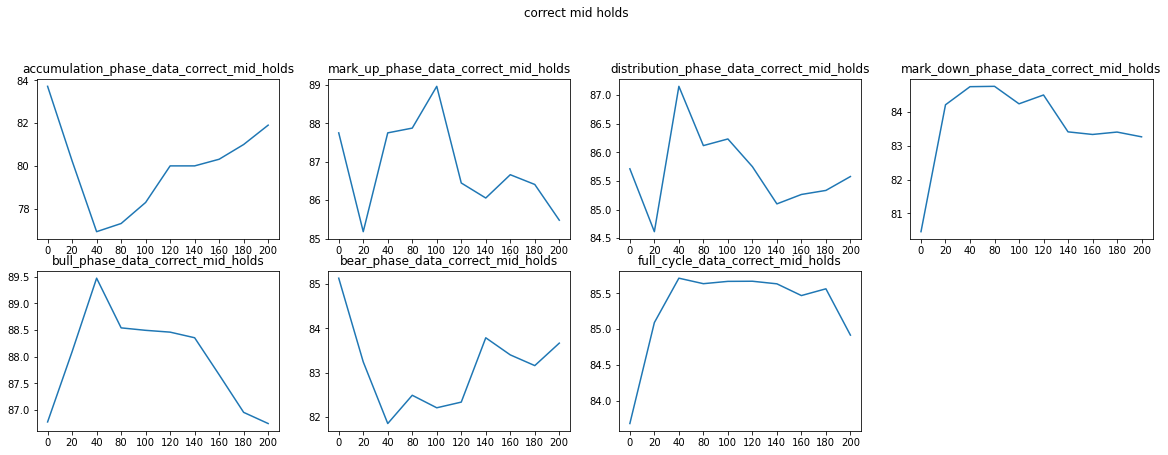

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_mid_holds")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_mid_holds")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_mid_holds")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_mid_holds")

Text(0.5, 1.0, 'full_cycle_data_profit')

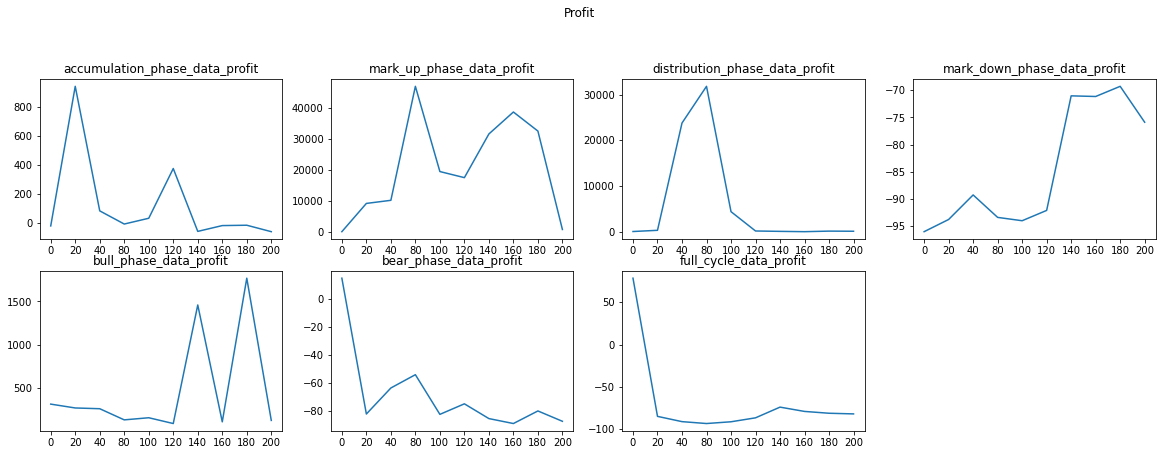

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Profit")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_profit")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_profit")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_profit")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_profit")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_profit")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_profit")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_profit")